# Decision tree for enumeration queries
## SparkSQL, basic features

In [1]:
!pip install numpy==1.26.0
!pip install scikit-learn==1.5.0
!pip install statsmodels==0.14.2
!pip install matplotlib==3.9.0
!pip install seaborn==0.13.2
#!pip install torch==1.13.1
#!pip install tqdm==4.66.4
#!pip install dhg==0.9.4

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.tree import plot_tree
from sklearn.tree import export_text

In [3]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'DejaVu Serif'
plt.rcParams['figure.dpi'] = 600

### Import the data

In [4]:
file_path = 'results/features_times_SPA_full_enum_infos.csv'
df = pd.read_csv(file_path)
df.head()

bench                query orig/rewr(med)            orig(med)  \
0  STATS        001-014-full1           orig  0.23393607139587402   
1  STATS        001-014-full2           orig  0.22921180725097656   
2  STATS        001-014-full3           orig  0.22890520095825195   
3  STATS  001-014-augF1-full1           orig  0.27040696144104004   
4  STATS  001-014-augF1-full2           orig   0.2345128059387207   

            rewr(med)           stage0(med)           stage1(med)  \
0  0.5746369361877441  0.031246185302734375  0.020569562911987305   
1  0.5519716739654541  0.029332876205444336   0.02038741111755371   
2  0.5264458656311035  0.030534029006958008  0.020862102508544922   
3  0.7876770496368408   0.04864144325256348  0.036579132080078125   
4  0.6265854835510254   0.03719043731689453  0.028997421264648438   

            stage2(med)          stage3(med)  #relations  ...  \
0  0.029339075088500977   0.4817984104156494           3  ...   
1  0.028491973876953125  0.47310543060302734           3  ...   
2  0.027678728103637695   0.4458963871002197           3  ...   
3   0.05184578895568848   0.6506106853485107           3  ...   
4   0.03893017768859863   0.5011601448059082           3  ...   

   min(branching factors)  max(branching factors)  mean(branching factors)  \
0                       2                       2                      2.0   
1                       2                       2                      2.0   
2                       2                       2                      2.0   
3                       2                       2                      2.0   
4                       2                       2                      2.0   

   median(branching factors)  q25(branching factors)  q75(branching factors)  \
0                        2.0                     2.0                     2.0   
1                        2.0                     2.0                     2.0   
2                        2.0                     2.0                     2.0   
3                        2.0                     2.0                     2.0   
4                        2.0                     2.0                     2.0   

   balancedness factor                          container counts list  \
0                  1.0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]   
1                  1.0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]   
2                  1.0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]   
3                  1.0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]   
4                  1.0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]   

   branching factors list                                               text  
0                     [2]  SELECT u.Id, c.UserId FROM comments as c, vote...  
1                     [2]  SELECT v.UserId, u.Id FROM comments as c, vote...  
2                     [2]  SELECT u.Id, v.UserId FROM comments as c, vote...  
3                     [2]  SELECT u.Id, c.UserId FROM comments as c, vote...  
4                     [2]  SELECT v.UserId, u.Id FROM comments as c, vote...  

[5 rows x 30 columns]

In [5]:
df.dtypes

bench                         object
query                         object
orig/rewr(med)                object
orig(med)                     object
rewr(med)                     object
stage0(med)                   object
stage1(med)                   object
stage2(med)                   object
stage3(med)                   object
#relations                     int64
#conditions                    int64
#filters                       int64
#joins                         int64
depth                          int64
min(container counts)          int64
max(container counts)          int64
mean(container counts)       float64
q25(container counts)        float64
median(container counts)     float64
q75(container counts)        float64
min(branching factors)         int64
max(branching factors)         int64
mean(branching factors)      float64
median(branching factors)    float64
q25(branching factors)       float64
q75(branching factors)       float64
balancedness factor          float64
c

#### Delete those examples, where both methods gave a timeout

In [6]:
df[df["orig/rewr(med)"] == "-"].shape

(132, 30)

Some queries did not finish the evaluation within our timeout (100 sec). Therefore, we cannot conclude which variante is the better one and we delete those samples.

In cases where only one of the versions is giving a timeout, we set it the runtime to 100 to be able to work with them.

In [7]:
df = df[df["orig/rewr(med)"] != "-"]
df.shape

(1609, 30)

In [8]:
df[df["orig(med)"] == "TO"].shape

(53, 30)

In [9]:
df['orig(med)'] = df['orig(med)'].replace("TO", 100)

In [10]:
df[df["rewr(med)"] == "TO"].shape

(5, 30)

In [11]:
df['rewr(med)'] = df['rewr(med)'].replace("TO", 100)

In [12]:
df["orig(med)"] = df["orig(med)"].astype(float)

In [13]:
df["rewr(med)"] = df["rewr(med)"].astype(float)

#### Get the feature matrix

Get the features matrix X and the response variables y1 and y1, where once the rewritting time and the evaluation time are taken into consideration and once only the evaluation time. Additionally the response variables have to have numbers in it and we assign 1 = rewr and 0 = orig.

In [14]:
X = df.iloc[:, 9:26]
X.head()

#relations  #conditions  #filters  #joins  depth  min(container counts)  \
0           3            7         5       2      1                      1   
1           3            7         5       2      1                      1   
2           3            7         5       2      1                      1   
3           3            7         5       2      1                      1   
4           3            7         5       2      1                      1   

   max(container counts)  mean(container counts)  q25(container counts)  \
0                      3                1.133333                    1.0   
1                      3                1.133333                    1.0   
2                      3                1.133333                    1.0   
3                      3                1.133333                    1.0   
4                      3                1.133333                    1.0   

   median(container counts)  q75(container counts)  min(branching factors)  \
0                       1.0                    1.0                       2   
1                       1.0                    1.0                       2   
2                       1.0                    1.0                       2   
3                       1.0                    1.0                       2   
4                       1.0                    1.0                       2   

   max(branching factors)  mean(branching factors)  median(branching factors)  \
0                       2                      2.0                        2.0   
1                       2                      2.0                        2.0   
2                       2                      2.0                        2.0   
3                       2                      2.0                        2.0   
4                       2                      2.0                        2.0   

   q25(branching factors)  q75(branching factors)  
0                     2.0                     2.0  
1                     2.0                     2.0  
2                     2.0                     2.0  
3                     2.0                     2.0  
4                     2.0                     2.0

#### Log-transformations

This basic features do not need log transformations.

In [15]:
min_values = X.min()
max_values = X.max()
diff = max_values-min_values

pd.DataFrame({'Min': min_values, 'Max': max_values, 'Diff': diff})

Min   Max       Diff
#relations                 2.000000  11.0   9.000000
#conditions                2.000000  20.0  18.000000
#filters                   0.000000  16.0  16.000000
#joins                     1.000000  12.0  11.000000
depth                      1.000000   4.0   3.000000
min(container counts)      1.000000   1.0   0.000000
max(container counts)      2.000000   5.0   3.000000
mean(container counts)     1.047619   1.6   0.552381
q25(container counts)      1.000000   1.0   0.000000
median(container counts)   1.000000   1.0   0.000000
q75(container counts)      1.000000   1.5   0.500000
min(branching factors)     1.000000   6.0   5.000000
max(branching factors)     1.000000   6.0   5.000000
mean(branching factors)    1.000000   6.0   5.000000
median(branching factors)  1.000000   6.0   5.000000
q25(branching factors)     1.000000   6.0   5.000000
q75(branching factors)     1.000000   6.0   5.000000

In [16]:
X.hist(layout=(11, 3), figsize=(20, 25))
plt.show()

#### Classification response

Get the column(s) where we have "orig" or "rewr", depending on which method was faster. We now want to encode this as 0 (evaluating the original query faster) and 1 (evaluating the rewritten query faster).

In [17]:
mapping = {'orig': 0, 'rewr': 1}
y1 = df['orig/rewr(med)'].map(mapping)
#y1.head()

The number of appearances of original and rewritten is very balanced.

In [18]:
y1.value_counts()

orig/rewr(med)
0    1547
1      62
Name: count, dtype: int64

In [19]:
count = y1.value_counts().tolist()[::-1] + ["-"]
count = pd.Series(count)
count.index = ["rewr", "orig", "equal"]
count

rewr       62
orig     1547
equal       -
dtype: object

In [20]:
df["orig/rewr(med)"].value_counts()

orig/rewr(med)
orig    1547
rewr      62
Name: count, dtype: int64

#### Train-validation-test split

We split the dataset such that each benchmark dataset is represented in the train and in the test set (stratification). We do a 80% train, 10% validation and 10% test split.

In [21]:
stratification_df = df[df["bench"].isin(["STATS", "JOB", "HETIO"])]
lsqb_df = df[df["bench"] == "LSQB"]
snap_df = df[df["bench"] == "SNAP"]

stratification_X = X.loc[stratification_df.index]
lsqb_X = X.loc[lsqb_df.index]
snap_X = X.loc[snap_df.index]

stratification_y1 = y1.loc[stratification_df.index]
lsqb_y1 = y1.loc[lsqb_df.index]
snap_y1 = y1.loc[snap_df.index]

lsqb_choice = np.random.choice(3,3,replace=False)
snap_choice = np.random.choice(3,3,replace=False)

In [22]:
stratification_X_train, stratification_X_test, stratification_y1_train, stratification_y1_test = train_test_split(stratification_X, 
                        stratification_y1, test_size=0.2, stratify=stratification_df["bench"], random_state=40)
stratification_X_val, stratification_X_test, stratification_y1_val, stratification_y1_test = train_test_split(stratification_X_test, 
                        stratification_y1_test, test_size=0.5, stratify=stratification_df.loc[stratification_X_test.index]["bench"], random_state=40)
X_train = pd.concat([stratification_X_train, lsqb_X.iloc[lsqb_choice[0]].to_frame().T, snap_X.iloc[snap_choice[0]].to_frame().T], axis = 0)
X_val = pd.concat([stratification_X_val, lsqb_X.iloc[lsqb_choice[1]].to_frame().T, snap_X.iloc[snap_choice[1]].to_frame().T], axis = 0)
X_test = pd.concat([stratification_X_test, lsqb_X.iloc[lsqb_choice[2]].to_frame().T, snap_X.iloc[snap_choice[2]].to_frame().T], axis = 0)
y1_train = pd.concat([stratification_y1_train, pd.Series([lsqb_y1.iloc[lsqb_choice[0]]]), pd.Series([snap_y1.iloc[snap_choice[0]]])], axis = 0)
y1_val = pd.concat([stratification_y1_val, pd.Series([lsqb_y1.iloc[lsqb_choice[1]]]), pd.Series([snap_y1.iloc[snap_choice[1]]])], axis = 0)
y1_test = pd.concat([stratification_y1_test, pd.Series([lsqb_y1.iloc[lsqb_choice[2]]]), pd.Series([snap_y1.iloc[snap_choice[2]]])], axis = 0)

### Facts about the test set and runtime differences

In [23]:
y1_test.value_counts()

0    154
1      7
Name: count, dtype: int64

In [24]:
#df["diff rewr-orig"] = df["rewr(med)"] - df["orig(med)"]
df["diff rewr-orig"] = np.where(
    df["rewr(med)"] == 100, 100,
    np.where(
        df["orig(med)"] == 100, -100, 
        df["rewr(med)"] - df["orig(med)"] 
    )
)

In [25]:
diff_rewr = df.loc[df["diff rewr-orig"] < 0]
diff_orig = df.loc[df["diff rewr-orig"] >= 0]

In [26]:
bins = [0, 0.01, 0.1, 1, 10, 99.99, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']

diff_rewr["cut"] = pd.cut(abs(diff_rewr["diff rewr-orig"]), bins=bins, labels=labels)
diff_orig["cut"] = pd.cut(abs(diff_orig["diff rewr-orig"]), bins=bins, labels=labels)

table_rewr = diff_rewr.groupby('cut').size().reset_index(name = "rewr")
table_orig = diff_orig.groupby('cut').size().reset_index(name = "orig")

table = pd.merge(table_rewr, table_orig, on='cut', how='outer')
table = table.set_index('cut').T
#table.index = ['FP', 'FN']
table

/tmp/ipykernel_6207/1750407932.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_rewr["cut"] = pd.cut(abs(diff_rewr["diff rewr-orig"]), bins=bins, labels=labels)
/tmp/ipykernel_6207/1750407932.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_orig["cut"] = pd.cut(abs(diff_orig["diff rewr-orig"]), bins=bins, labels=labels)
/tmp/ipykernel_6207/1750407932.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False

cut   0.01  0.1     1   10  100  TO
rewr     0    0     0    3    6  53
orig     0    9  1234  275   24   5

In [27]:
diff_rewr = df.loc[y1_test[y1_test == 1].index]
diff_orig = df.loc[y1_test[y1_test == 0].index]

In [28]:
bins = [0, 0.01, 0.1, 1, 10, 99.99, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']

diff_rewr["cut"] = pd.cut(abs(diff_rewr["diff rewr-orig"]), bins=bins, labels=labels)
diff_orig["cut"] = pd.cut(abs(diff_orig["diff rewr-orig"]), bins=bins, labels=labels)

table_rewr = diff_rewr.groupby('cut').size().reset_index(name = "rewr")
table_orig = diff_orig.groupby('cut').size().reset_index(name = "orig")

table = pd.merge(table_rewr, table_orig, on='cut', how='outer')
table = table.set_index('cut').T
#table.index = ['FP', 'FN']
table

/tmp/ipykernel_6207/1750407932.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  table_rewr = diff_rewr.groupby('cut').size().reset_index(name = "rewr")
/tmp/ipykernel_6207/1750407932.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  table_orig = diff_orig.groupby('cut').size().reset_index(name = "orig")


cut   0.01  0.1    1  10  100  TO
rewr     0    0    1   0    0   6
orig     0    1  125  26    2   0

### Train a decision tree and observe the results on the test set

In [29]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_train)
y1_pred_dec_tree = clf.predict(X_test)

In [30]:
accuracy = accuracy_score(y1_test, y1_pred_dec_tree)
print(accuracy)
precision = precision_score(y1_test, y1_pred_dec_tree)
print(precision)
recall = recall_score(y1_test, y1_pred_dec_tree)
print(recall)
conf_matrix = confusion_matrix(y1_test, y1_pred_dec_tree)
conf_matrix

0.9937888198757764
0.875
1.0


array([[153,   1],
       [  0,   7]])

#### Get some statistics about the original runtimes, the rewritten runtimes, the decision runtimes and the true runtimes

In [31]:
test_set = df.loc[y1_test.index]

In [32]:
test_set["decision"] = y1_pred_dec_tree

In [33]:
test_set["faster runtime true"] = np.where(
    (test_set["orig/rewr(med)"] == "orig"), 
    test_set["orig(med)"], 
    test_set["rewr(med)"]
)

In [34]:
test_set["faster runtime dec"] = np.where(
    (test_set["decision"] == 0), 
    test_set["orig(med)"], 
    test_set["rewr(med)"]
)

In [35]:
summary_data = {
    "orig": [
        test_set["orig(med)"].sum(),
        test_set["orig(med)"].mean(),
        test_set["orig(med)"].min(),
        test_set["orig(med)"].max(),
        test_set["orig(med)"].median(),
        test_set["orig(med)"].std()
    ],
    "rewr": [
        test_set["rewr(med)"].sum(),
        test_set["rewr(med)"].mean(),
        test_set["rewr(med)"].min(),
        test_set["rewr(med)"].max(),
        test_set["rewr(med)"].median(),
        test_set["rewr(med)"].std()
    ],
    "dec": [
        test_set["faster runtime dec"].sum(),
        test_set["faster runtime dec"].mean(),
        test_set["faster runtime dec"].min(),
        test_set["faster runtime dec"].max(),
        test_set["faster runtime dec"].median(),
        test_set["faster runtime dec"].std()
    ],
    "true": [
        test_set["faster runtime true"].sum(),
        test_set["faster runtime true"].mean(),
        test_set["faster runtime true"].min(),
        test_set["faster runtime true"].max(),
        test_set["faster runtime true"].median(),
        test_set["faster runtime true"].std()
    ]
}

# Create a DataFrame using the summary data
summary_table = pd.DataFrame(
    summary_data,
    index=["sum", "mean","median", "std", "min", "max"]
)

# Display the table
summary_table

orig        rewr         dec        true
sum     778.392094  456.619504  265.239481  264.379228
mean      4.834734    2.836146    1.647450    1.642107
median    0.056547    0.169746    0.056547    0.056547
std     100.000000   77.431941   77.431941   77.431941
min       0.362965    0.830397    0.382674    0.362965
max      19.164442    8.925568    7.122172    7.123067

#### Inspection of the misclassifications

In [36]:
misclass = df.loc[X_test.index]
misclass.insert(0, 'true label', np.array(y1_test))
misclass.insert(0, 'pred label', y1_pred_dec_tree)
indices_not_equal = np.where(y1_test != y1_pred_dec_tree)[0]
misclass = misclass.iloc[indices_not_equal]
misclass

pred label  true label  bench                query orig/rewr(med)  \
96           1           0  STATS  011-050-augF2-full1           orig   

    orig(med)  rewr(med)           stage0(med)          stage1(med)  \
96   0.236521   0.756072  0.028258562088012695  0.04019308090209961   

            stage2(med)  ... max(branching factors)  mean(branching factors)  \
96  0.06513714790344238  ...                      4                      4.0   

    median(branching factors)  q25(branching factors)  q75(branching factors)  \
96                        4.0                     4.0                     4.0   

    balancedness factor                              container counts list  \
96                  1.0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   

    branching factors list                                               text  \
96                     [4]  SELECT v.UserId, c.UserId FROM comments as c, ...   

    diff rewr-orig  
96        0.519552  

[1 rows x 33 columns]

In [37]:
print("Default font size:", plt.rcParams['font.size'])

Default font size: 10.0


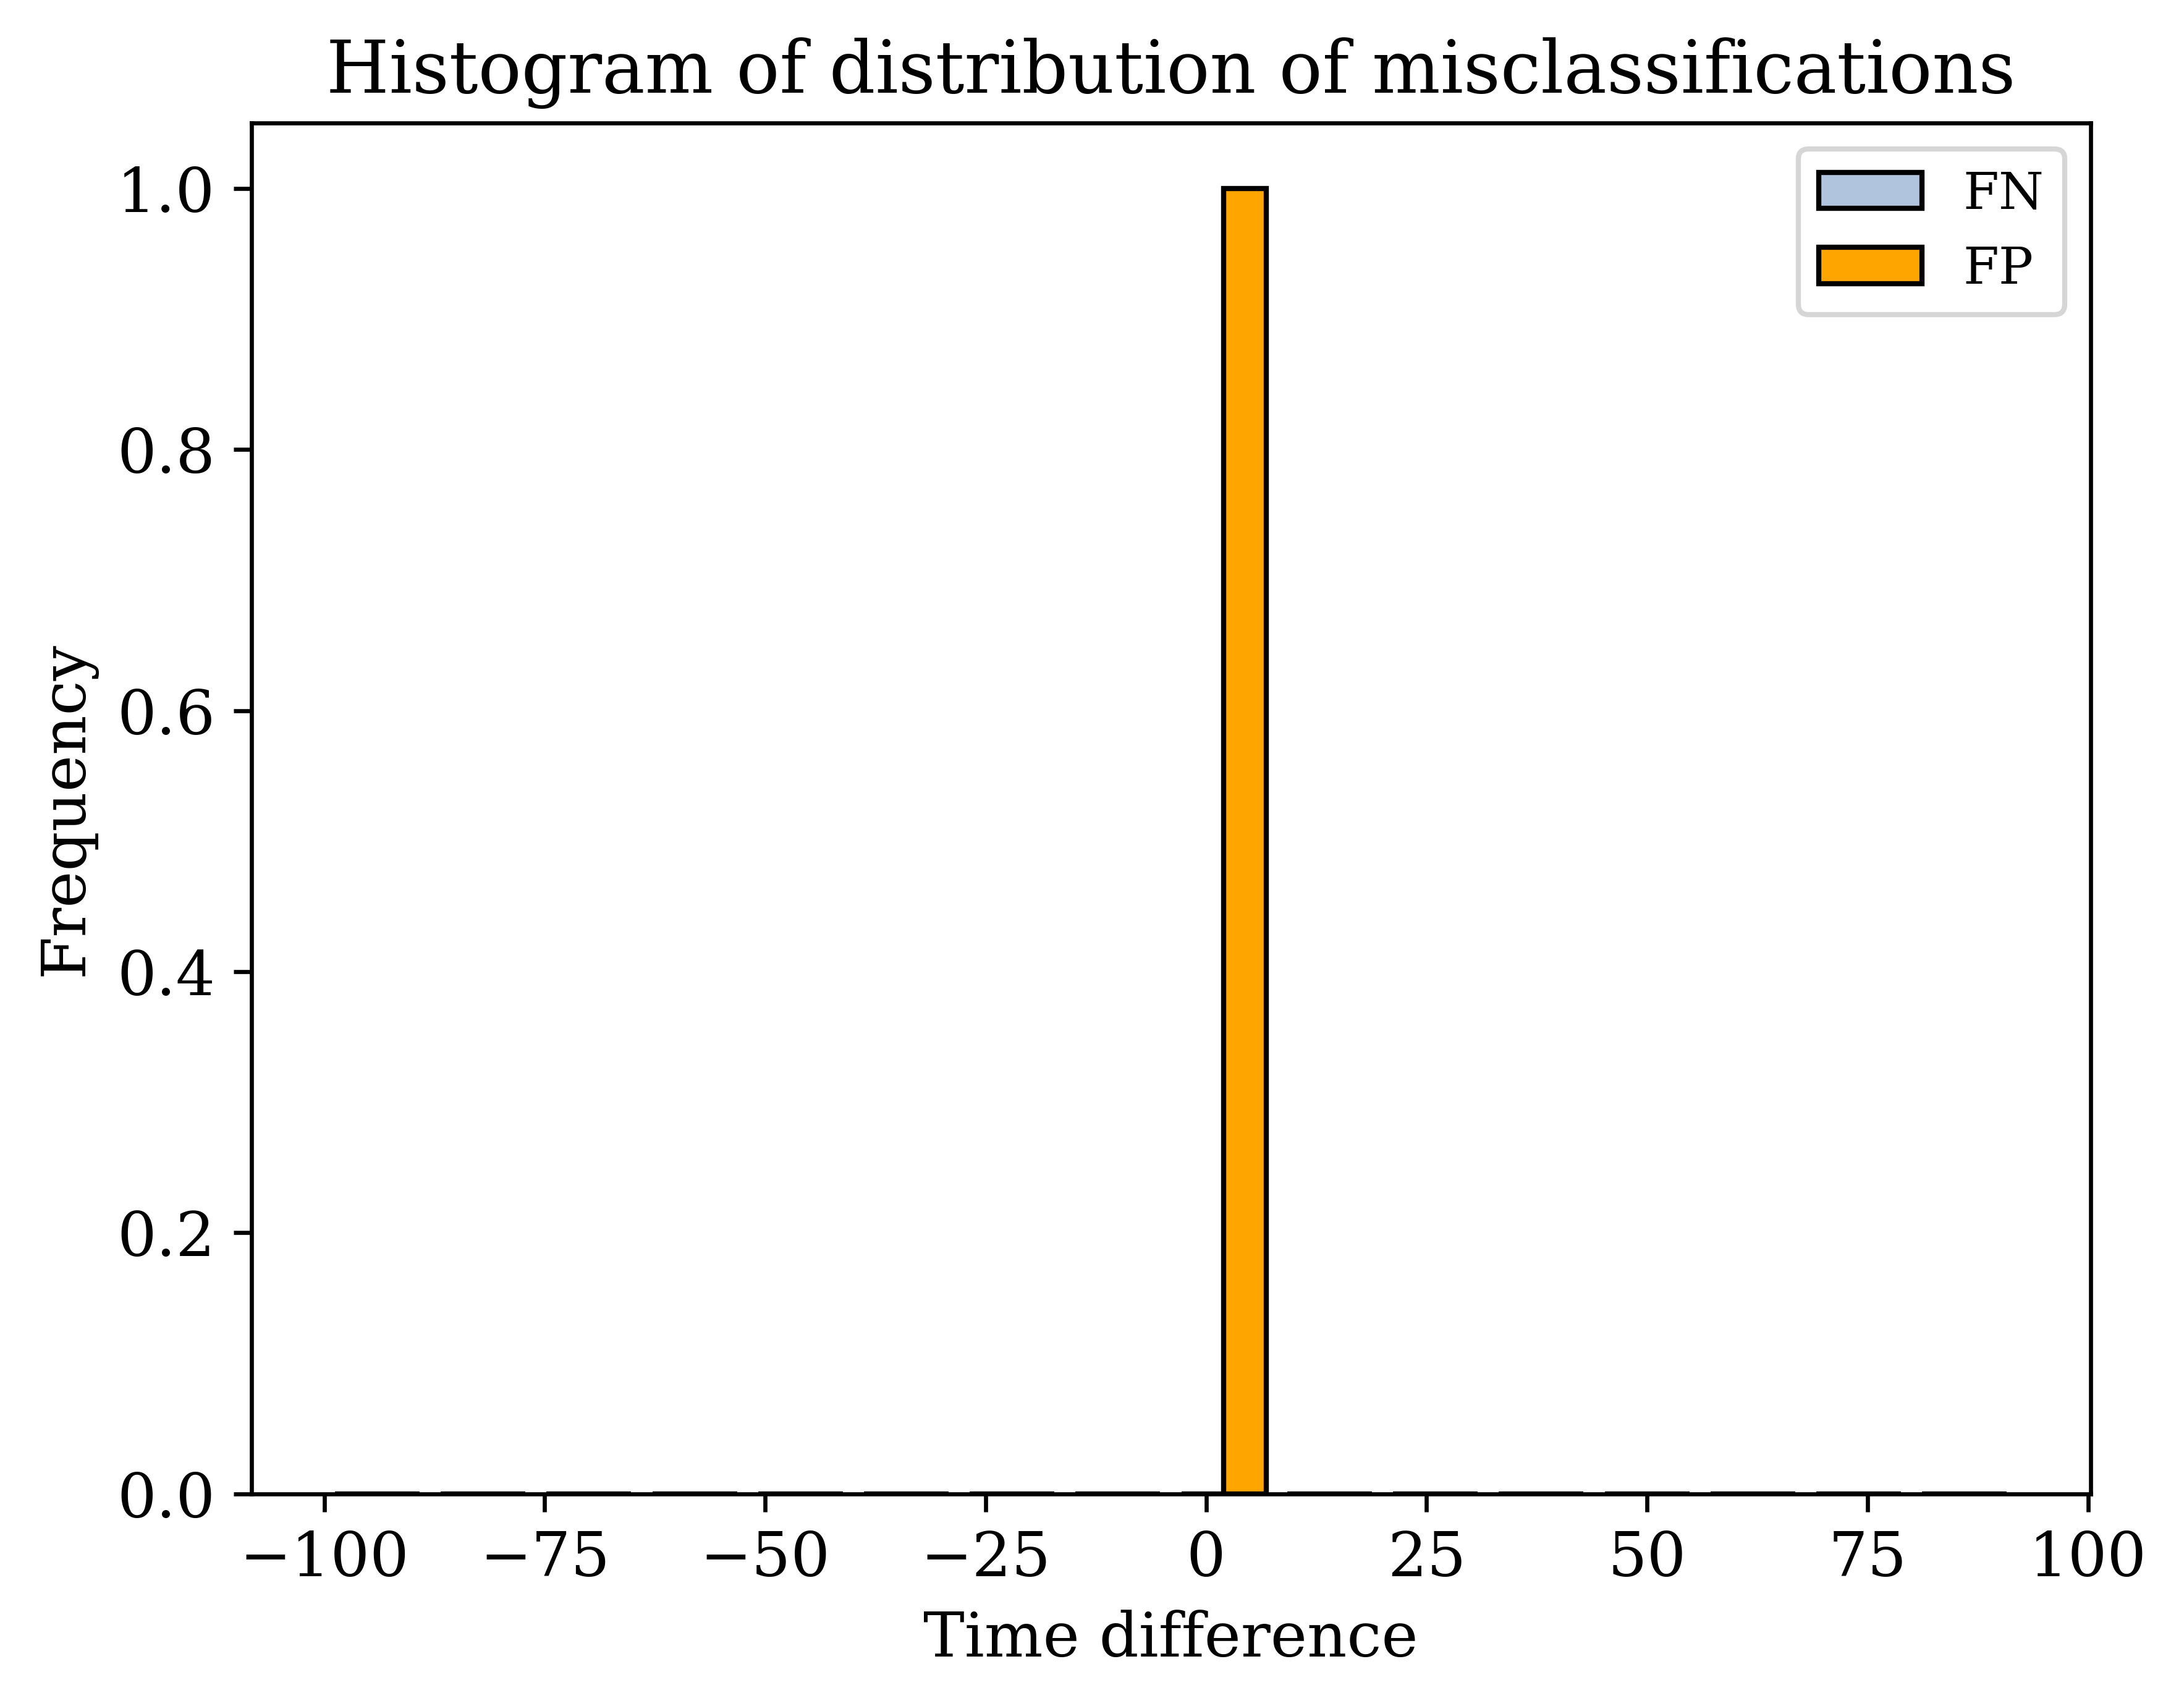

In [38]:
diff_0 = misclass[misclass['pred label'] == 0]['diff rewr-orig']
diff_1 = misclass[misclass['pred label'] == 1]['diff rewr-orig']

# Plotting the histogram
bins=list(range(-100, 101, 12))
plt.hist([diff_0, diff_1], bins=bins, edgecolor='black', color=['lightsteelblue', 'orange'], label=['FN', 'FP'])

# Adding labels and title
plt.xlabel('Time difference', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.title('Histogram of distribution of misclassifications', fontsize = 14)
plt.legend(title='')
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12)

plt.savefig('plots/SPA_enum_dec_tree_misclass_hist.png')
# Show the plot
plt.show()

In [39]:
bins = [0, 0.01, 0.1, 1, 10, 99.99, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']

misclass_1 = misclass[misclass["pred label"] == 1]
misclass_0 = misclass[misclass["pred label"] == 0]

misclass_1["cut"] = pd.cut(abs(misclass_1['diff rewr-orig']), bins=bins, labels=labels)
misclass_0["cut"] = pd.cut(abs(misclass_0['diff rewr-orig']), bins=bins, labels=labels)

table_1 = misclass_1.groupby('cut').size().reset_index(name='count_1')
table_0 = misclass_0.groupby('cut').size().reset_index(name='count_0')

table = pd.merge(table_1, table_0, on='cut', how='outer')
table = table.set_index('cut').T
table.index = ['FP', 'FN']
table

/tmp/ipykernel_6207/2371796600.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  table_1 = misclass_1.groupby('cut').size().reset_index(name='count_1')
/tmp/ipykernel_6207/2371796600.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  table_0 = misclass_0.groupby('cut').size().reset_index(name='count_0')


cut  0.01  0.1  1  10  100  TO
FP      0    0  1   0    0   0
FN      0    0  0   0    0   0

#### Statistical tests

In [40]:
test_set = df.loc[X_test.index]
test_set.insert(0, 'true label', np.array(y1_test))
test_set.insert(0, 'pred label', y1_pred_dec_tree)

In [41]:
test_set['pred(med)'] = np.where(test_set['pred label'] == 0, test_set['orig(med)'], test_set['rewr(med)'])
test_set.head()

pred label  true label  bench                    query orig/rewr(med)  \
362            0           0  STATS            043-076-full1           orig   
1732           1           1  HETIO  16-01-SpDtCuGrGuA-full1           rewr   
982            0           0  STATS      115-144-augF1-full1           orig   
573            0           0  STATS      066-094-augF1-full2           orig   
1446           0           0    JOB           3c-augF2-full3           orig   

       orig(med)  rewr(med)           stage0(med)           stage1(med)  \
362     0.429375   1.156149  0.033330440521240234  0.061911821365356445   
1732  100.000000   5.106626   0.06851053237915039   0.13383173942565918   
982     0.479718   1.120496  0.031218528747558594  0.059717416763305664   
573     0.056547   0.173982  0.020437002182006836  0.016481399536132812   
1446    6.938535  10.763336   0.03356623649597168   0.03142738342285156   

              stage2(med)  ... mean(branching factors)  \
362   0.10638260841369629  ...                     5.0   
1732   0.5489814281463623  ...                     2.0   
982   0.10008025169372559  ...                     5.0   
573   0.02305746078491211  ...                     2.0   
1446  0.04931044578552246  ...                     3.0   

      median(branching factors)  q25(branching factors)  \
362                         5.0                     5.0   
1732                        2.0                     1.0   
982                         5.0                     5.0   
573                         2.0                     2.0   
1446                        3.0                     3.0   

      q75(branching factors)  balancedness factor  \
362                      5.0                 1.00   
1732                     3.0                 0.75   
982                      5.0                 1.00   
573                      2.0                 1.00   
1446                     3.0                 1.00   

                                  container counts list  \
362   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
1732  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
982   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
573   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
1446  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   

      branching factors list  \
362                      [5]   
1732         [2, 1, 1, 3, 3]   
982                      [5]   
573                      [2]   
1446                     [3]   

                                                   text  diff rewr-orig  \
362   SELECT p.Id, b.UserId FROM comments as c, post...        0.726774   
1732  SELECT t.sid, p.sid FROM symptom s, presents p...     -100.000000   
982   SELECT v.PostId, u.Id FROM comments as c, post...        0.640778   
573   SELECT p.OwnerUserId, v.UserId FROM votes as v...        0.117435   
1446  SELECT t.id, k.id FROM keyword AS k, movie_inf...        3.824801   

      pred(med)  
362    0.429375  
1732   5.106626  
982    0.479718  
573    0.056547  
1446   6.938535  

[5 rows x 34 columns]

The Wilcoxon rank test is to compare medians (of dependent groups).  
The Nullhypothesis is that the medians are equal. If the p-value is smaller than a chosen alpha value, we can reject the null and say that the median with only original runtimes is significantly different to the median of the chosen versions.

In [42]:
w_stat, p_val = stats.wilcoxon(test_set["orig(med)"], test_set["pred(med)"])

print(f"Wilcoxon statistic: {w_stat}")
print(f"P-value: {p_val}")

Wilcoxon statistic: 1.0
P-value: 0.017290280592906253


The paired sample t-test is to compare means (of dependent groups).  
The Nullhypothesis is that the means are equal. If the p-value is smaller than a chosen alpha value, we can reject the null and say that the mean with only original runtimes is significantly different to the mean of the chosen versions.

In [43]:
t_stat, p_val = stats.ttest_rel(test_set["orig(med)"], test_set["pred(med)"])

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_val}")

T-statistic: 2.4512268827561168
P-value: 0.015313005039314117


#### Important features using Gini importance

In [44]:
feature_names = X.columns.tolist()
feature_importances = clf.feature_importances_
df_importances = pd.DataFrame(data=feature_importances, index=feature_names, columns=["Importance"])
df_importances.T

#relations  #conditions  #filters    #joins     depth  \
Importance         0.0     0.074441  0.198867  0.375744  0.020836   

            min(container counts)  max(container counts)  \
Importance                    0.0               0.005668   

            mean(container counts)  q25(container counts)  \
Importance                0.143227                    0.0   

            median(container counts)  q75(container counts)  \
Importance                       0.0                    0.0   

            min(branching factors)  max(branching factors)  \
Importance                     0.0                0.015423   

            mean(branching factors)  median(branching factors)  \
Importance                      0.0                   0.120463   

            q25(branching factors)  q75(branching factors)  
Importance                0.000715                0.044616

In [45]:
df_importances_sorted = df_importances.sort_values(by='Importance', ascending=False)  # Use ascending=True for ascending order
df_importances_sorted

Importance
#joins                       0.375744
#filters                     0.198867
mean(container counts)       0.143227
median(branching factors)    0.120463
#conditions                  0.074441
q75(branching factors)       0.044616
depth                        0.020836
max(branching factors)       0.015423
max(container counts)        0.005668
q25(branching factors)       0.000715
mean(branching factors)      0.000000
#relations                   0.000000
min(branching factors)       0.000000
q75(container counts)        0.000000
median(container counts)     0.000000
min(container counts)        0.000000
q25(container counts)        0.000000

#### Visualization of the decision tree

In [46]:
clf.tree_.max_depth

7

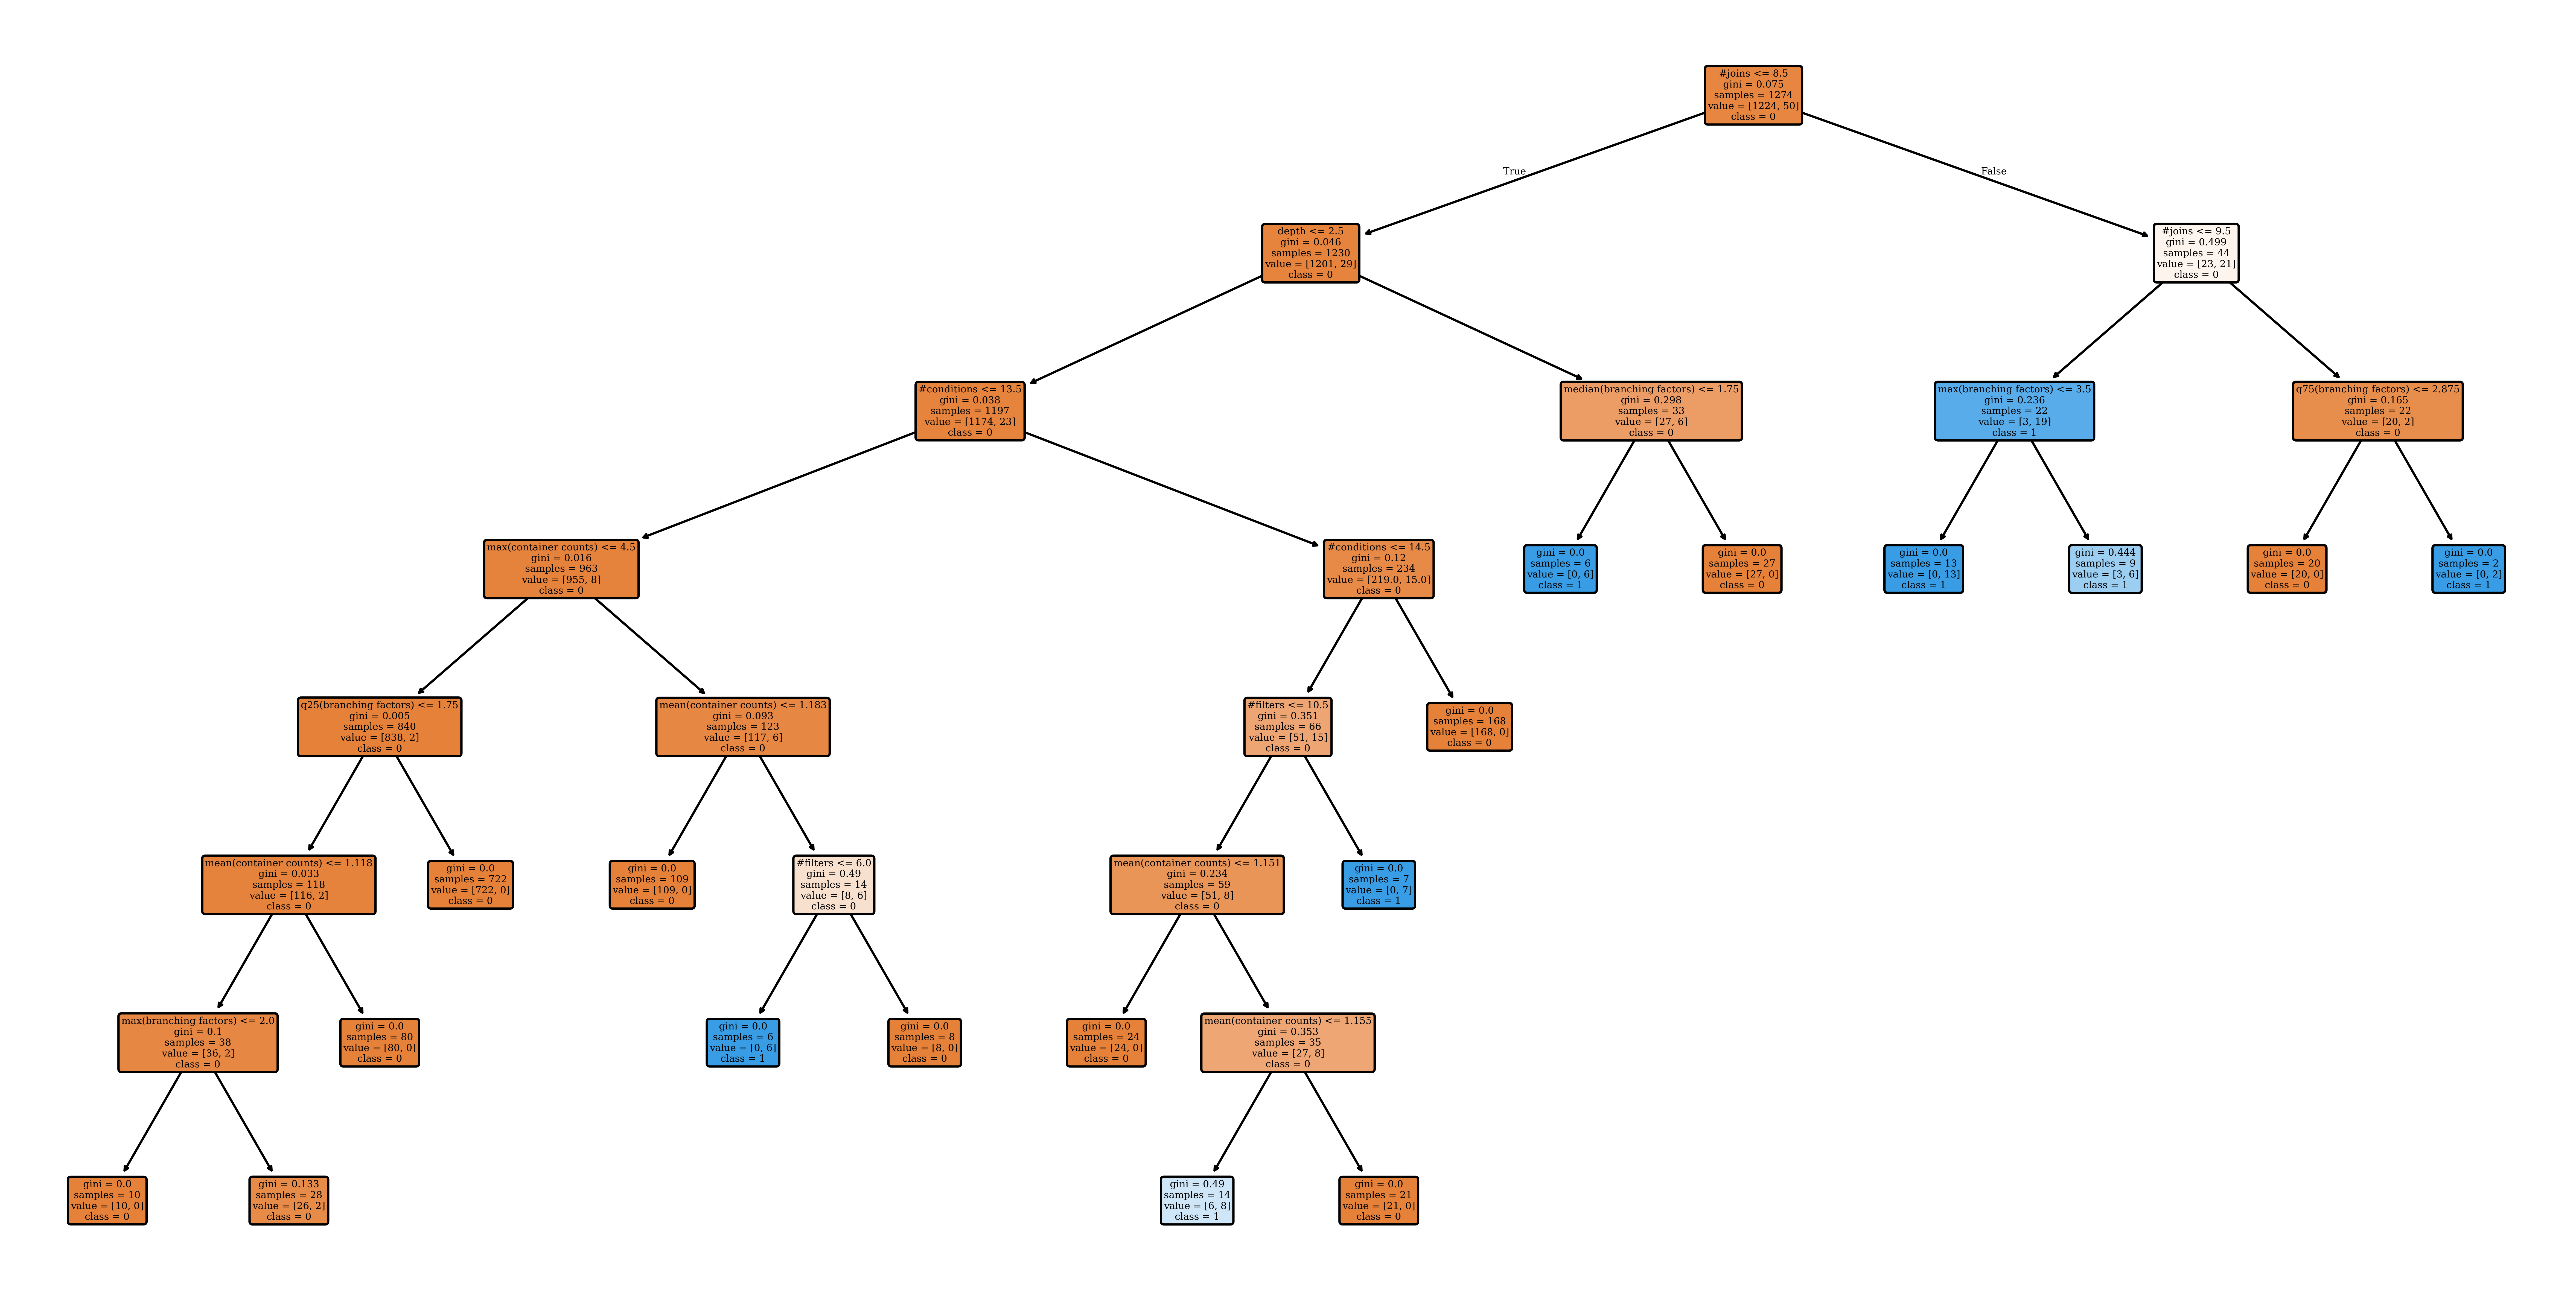

In [47]:
plt.figure(figsize=(20,10))  # Customize the size as needed
plot_tree(clf, filled=True, feature_names=X_train.columns, class_names=["0","1"], rounded=True)
plt.savefig('plots/SPA_enum_dec_tree_vis.png')
plt.show()

#### Plots of the runtime distributions

Plots of the distribution of the orders of magnitude for the final model on the test set in comparison to the original and rewritten plots

/tmp/ipykernel_6207/143753844.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_orig = test_set.groupby(['interval orig', 'bench']).size().unstack(fill_value=0)
/tmp/ipykernel_6207/143753844.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_rewr = test_set.groupby(['interval rewr', 'bench']).size().unstack(fill_value=0)
/tmp/ipykernel_6207/143753844.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

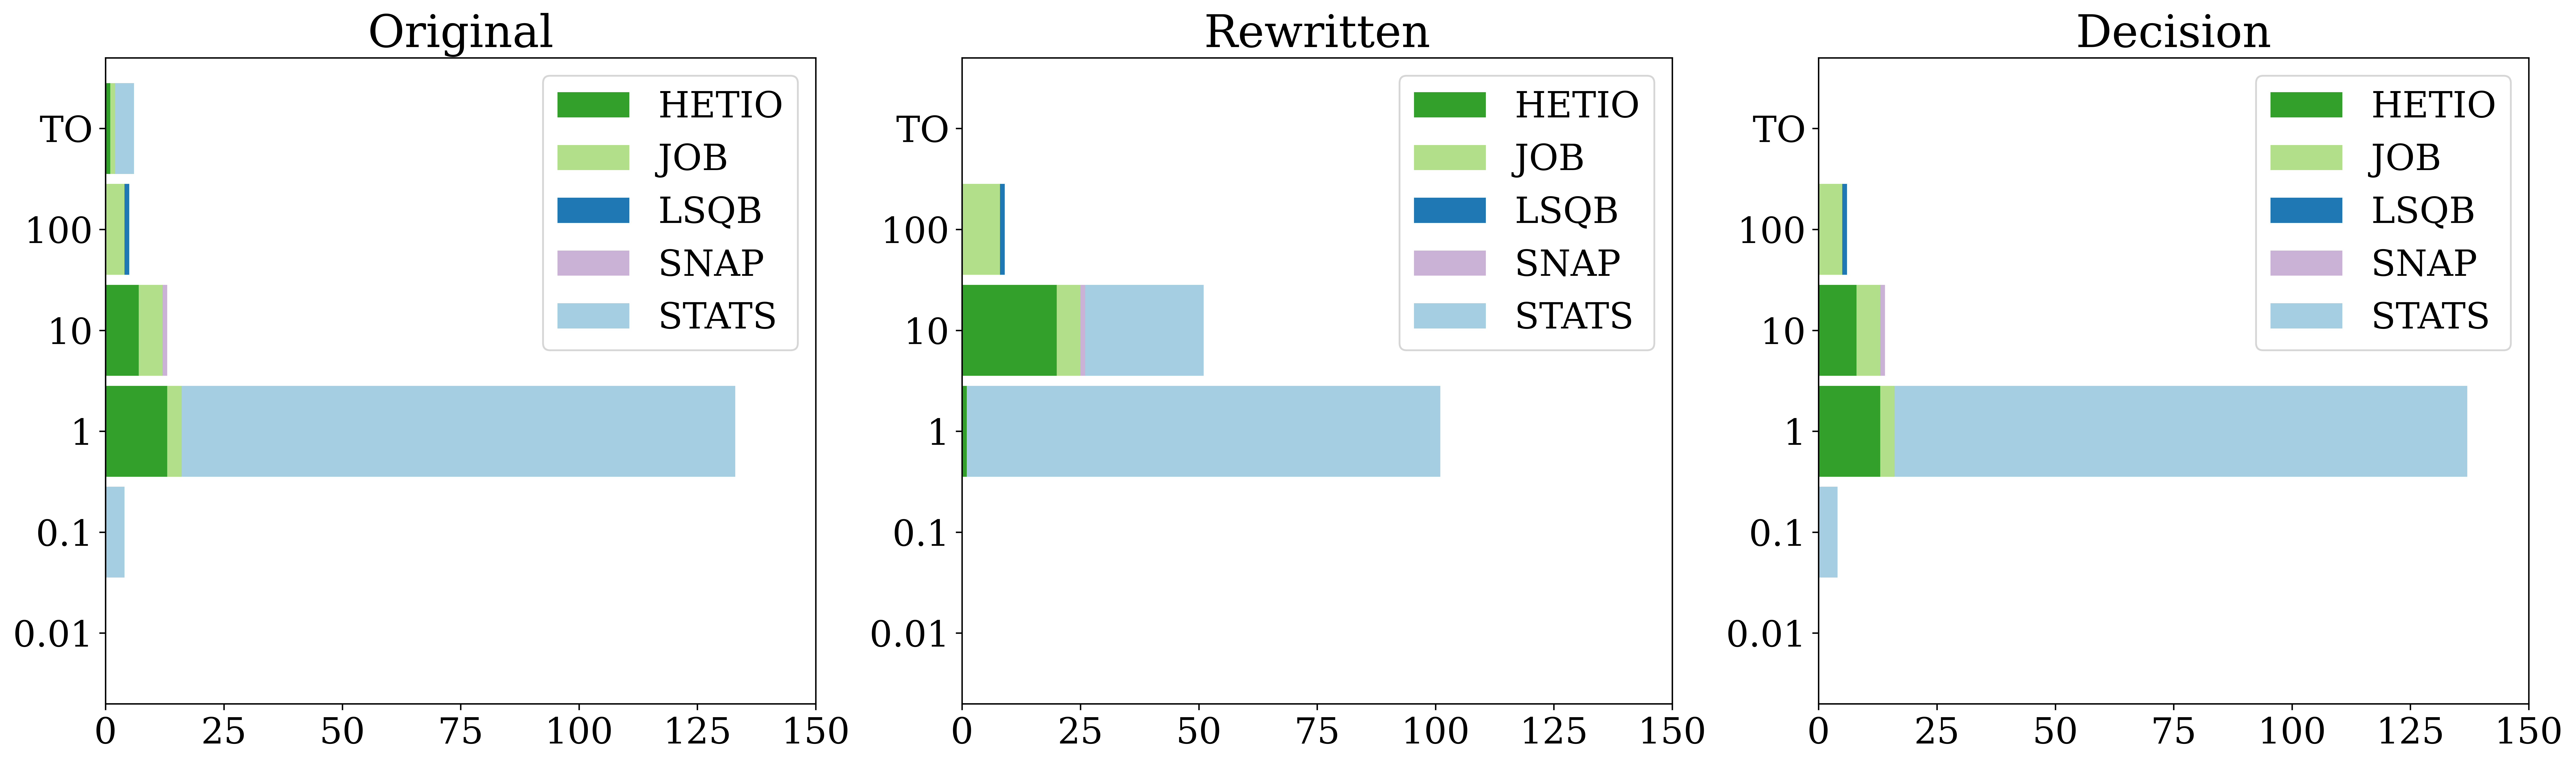

In [48]:
test_set["orig(med)"] = test_set['orig(med)'].astype("float64")
test_set["rewr(med)"] = test_set['rewr(med)'].astype("float64")
test_set["pred(med)"] = test_set['pred(med)'].astype("float64")
bins = [0, 0.01, 0.1, 1, 10, 99.99, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']
test_set['interval orig'] = pd.cut(test_set['orig(med)'], bins=bins, labels=labels)
test_set['interval rewr'] = pd.cut(test_set['rewr(med)'], bins=bins, labels=labels)
test_set['interval pred'] = pd.cut(test_set['pred(med)'], bins=bins, labels=labels)

grouped_orig = test_set.groupby(['interval orig', 'bench']).size().unstack(fill_value=0)
grouped_rewr = test_set.groupby(['interval rewr', 'bench']).size().unstack(fill_value=0)
grouped_pred = test_set.groupby(['interval pred', 'bench']).size().unstack(fill_value=0)

paired_colors = [
    '#a6cee3', '#1f78b4', '#b2df8a', '#33a02c',
    '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00',
    '#cab2d6', '#6a3d9a', '#ffff99', '#b15928'
]

category_colors = {
    'HETIO': paired_colors[3],
    'JOB': paired_colors[2],
    'LSQB': paired_colors[1],
    'SNAP': paired_colors[8],
    'STATS': paired_colors[0]
}

colors = [category_colors[col] for col in grouped_orig.columns]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

fontsize = 20
titlesize = 25
xlim = 150

# Plot for 'orig mean'
grouped_orig.plot(kind='barh', stacked=True, color=colors, ax=ax1, width = 0.9)
ax1.set_xlim(0,xlim)
#ax1.set_xlabel('Count', fontsize=fontsize)  # Increase font size for x-axis label
#ax1.set_ylabel('Order of magnitude', fontsize=fontsize)  # Increase font size for y-axis label
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_title('Original', fontsize=titlesize)  # Increase font size for title
ax1.legend(fontsize=fontsize)  # Increase font size for legend
ax1.tick_params(axis='both', which='major', labelsize=fontsize)

# Plot for 'rewr mean'
grouped_rewr.plot(kind='barh', stacked=True, color=colors, ax=ax2, width = 0.9)
#ax2.set_xlabel('Count', fontsize=fontsize)
#ax2.set_ylabel('Order of magnitude', fontsize=fontsize)
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('Rewritten', fontsize=titlesize)
ax2.legend(fontsize=fontsize)  
ax2.set_xlim(0,xlim)
ax2.tick_params(axis='both', which='major', labelsize=fontsize)

# Plot for 'pred mean'
grouped_pred.plot(kind='barh', stacked=True, color=colors, ax=ax3, width = 0.9)
#ax3.set_xlabel('Count', fontsize=fontsize)
#ax3.set_ylabel('Order of magnitude', fontsize=fontsize)
ax3.set_xlabel('')
ax3.set_ylabel('')
ax3.set_title('Decision', fontsize=titlesize)
ax3.legend(fontsize=fontsize)  
ax3.set_xlim(0,xlim)
ax3.tick_params(axis='both', which='major', labelsize=fontsize)

plt.tight_layout()
plt.savefig('plots/SPA_enum_runtimes_color_big.png')
plt.show()

/tmp/ipykernel_6207/1490644245.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_orig = test_set.groupby(['interval orig', 'bench']).size().unstack(fill_value=0)
/tmp/ipykernel_6207/1490644245.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_rewr = test_set.groupby(['interval rewr', 'bench']).size().unstack(fill_value=0)
/tmp/ipykernel_6207/1490644245.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warni

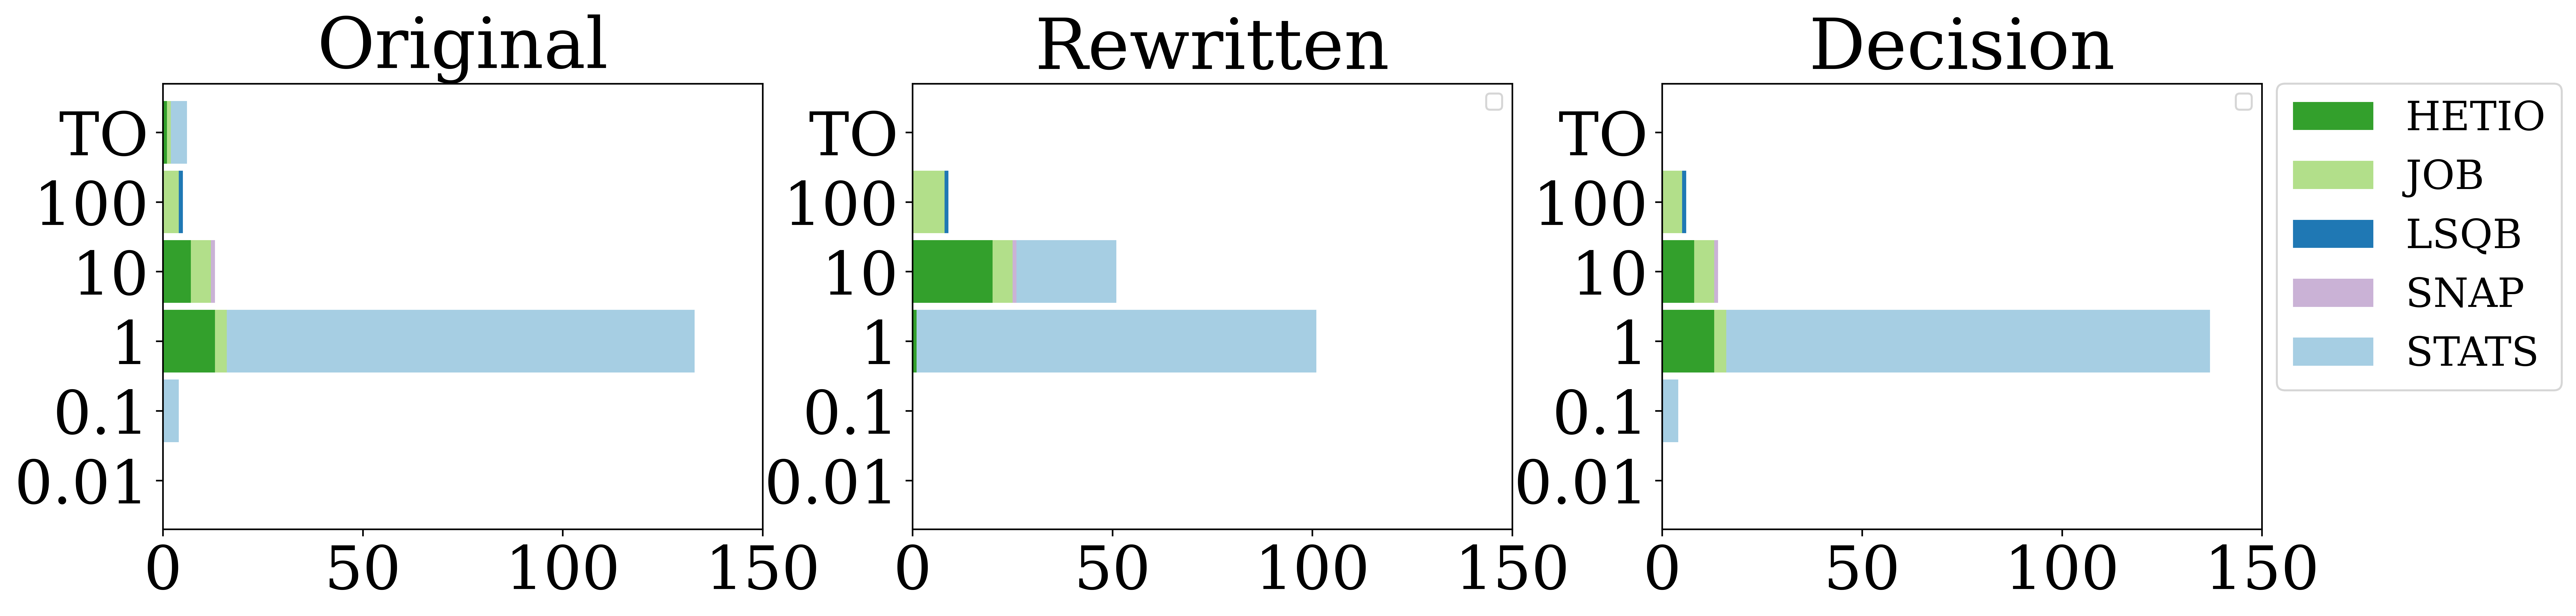

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming test_set is already defined and populated
test_set["orig(med)"] = test_set['orig(med)'].astype("float64")
test_set["rewr(med)"] = test_set['rewr(med)'].astype("float64")
test_set["pred(med)"] = test_set['pred(med)'].astype("float64")

bins = [0, 0.01, 0.1, 1, 10, 99.99, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']
test_set['interval orig'] = pd.cut(test_set['orig(med)'], bins=bins, labels=labels)
test_set['interval rewr'] = pd.cut(test_set['rewr(med)'], bins=bins, labels=labels)
test_set['interval pred'] = pd.cut(test_set['pred(med)'], bins=bins, labels=labels)

grouped_orig = test_set.groupby(['interval orig', 'bench']).size().unstack(fill_value=0)
grouped_rewr = test_set.groupby(['interval rewr', 'bench']).size().unstack(fill_value=0)
grouped_pred = test_set.groupby(['interval pred', 'bench']).size().unstack(fill_value=0)

paired_colors = [
    '#a6cee3', '#1f78b4', '#b2df8a', '#33a02c',
    '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00',
    '#cab2d6', '#6a3d9a', '#ffff99', '#b15928'
]

category_colors = {
    'HETIO': paired_colors[3],
    'JOB': paired_colors[2],
    'LSQB': paired_colors[1],
    'SNAP': paired_colors[8],
    'STATS': paired_colors[0]
}

colors = [category_colors[col] for col in grouped_orig.columns]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))

fontsize = 30
titlesize = 35
xlim = 150

# Plot for 'orig mean'
grouped_orig.plot(kind='barh', stacked=True, color=colors, ax=ax1, width = 0.9)
ax1.set_xlim(0, xlim)
#ax1.set_xlabel('Count', fontsize=fontsize)  # Increase font size for x-axis label
#ax1.set_ylabel('Order of magnitude', fontsize=fontsize)  # Increase font size for y-axis label
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_title('Original', fontsize=titlesize)
#ax1.legend(title='Benchmark', fontsize=fontsize)  # Removed individual legend for this subplot
ax1.tick_params(axis='both', which='major', labelsize=fontsize)

# Plot for 'rewr mean'
grouped_rewr.plot(kind='barh', stacked=True, color=colors, ax=ax2, width = 0.9)
ax2.set_xlabel('')
ax2.set_ylabel('')
#ax2.set_xlabel('Count', fontsize=fontsize)
#ax2.set_ylabel('Order of magnitude', fontsize=fontsize)
ax2.set_title('Rewritten', fontsize=titlesize)
#ax2.legend(title='Benchmark', fontsize=fontsize)  # Removed individual legend for this subplot
ax2.legend('')
ax2.set_xlim(0, xlim)
ax2.tick_params(axis='both', which='major', labelsize=fontsize)

# Plot for 'pred mean'
grouped_pred.plot(kind='barh', stacked=True, color=colors, ax=ax3, width = 0.9)
ax3.set_xlabel('')
ax3.set_ylabel('')
#ax3.set_xlabel('Count', fontsize=fontsize)
#ax3.set_ylabel('Order of magnitude', fontsize=fontsize)
ax3.set_title('Decision', fontsize=titlesize)
#ax3.legend(title='Benchmark', fontsize=fontsize)  # Removed individual legend for this subplot
ax3.legend('')
ax3.set_xlim(0, xlim)
ax3.tick_params(axis='both', which='major', labelsize=fontsize)

# Add a combined legend outside the plots
handles, labels = ax1.get_legend_handles_labels()  # Use handles from the first subplot
ax1.legend(handles, labels, fontsize=20, loc='upper right', bbox_to_anchor=(4, 1), borderaxespad=0.)

# Adjust layout to make room for the legend
#plt.tight_layout()
plt.subplots_adjust(wspace = 0.25, right=0.85)  # Adjust this value to make room for the legend

plt.savefig('plots/SPA_enum_runtimes_color.png') 
plt.show()


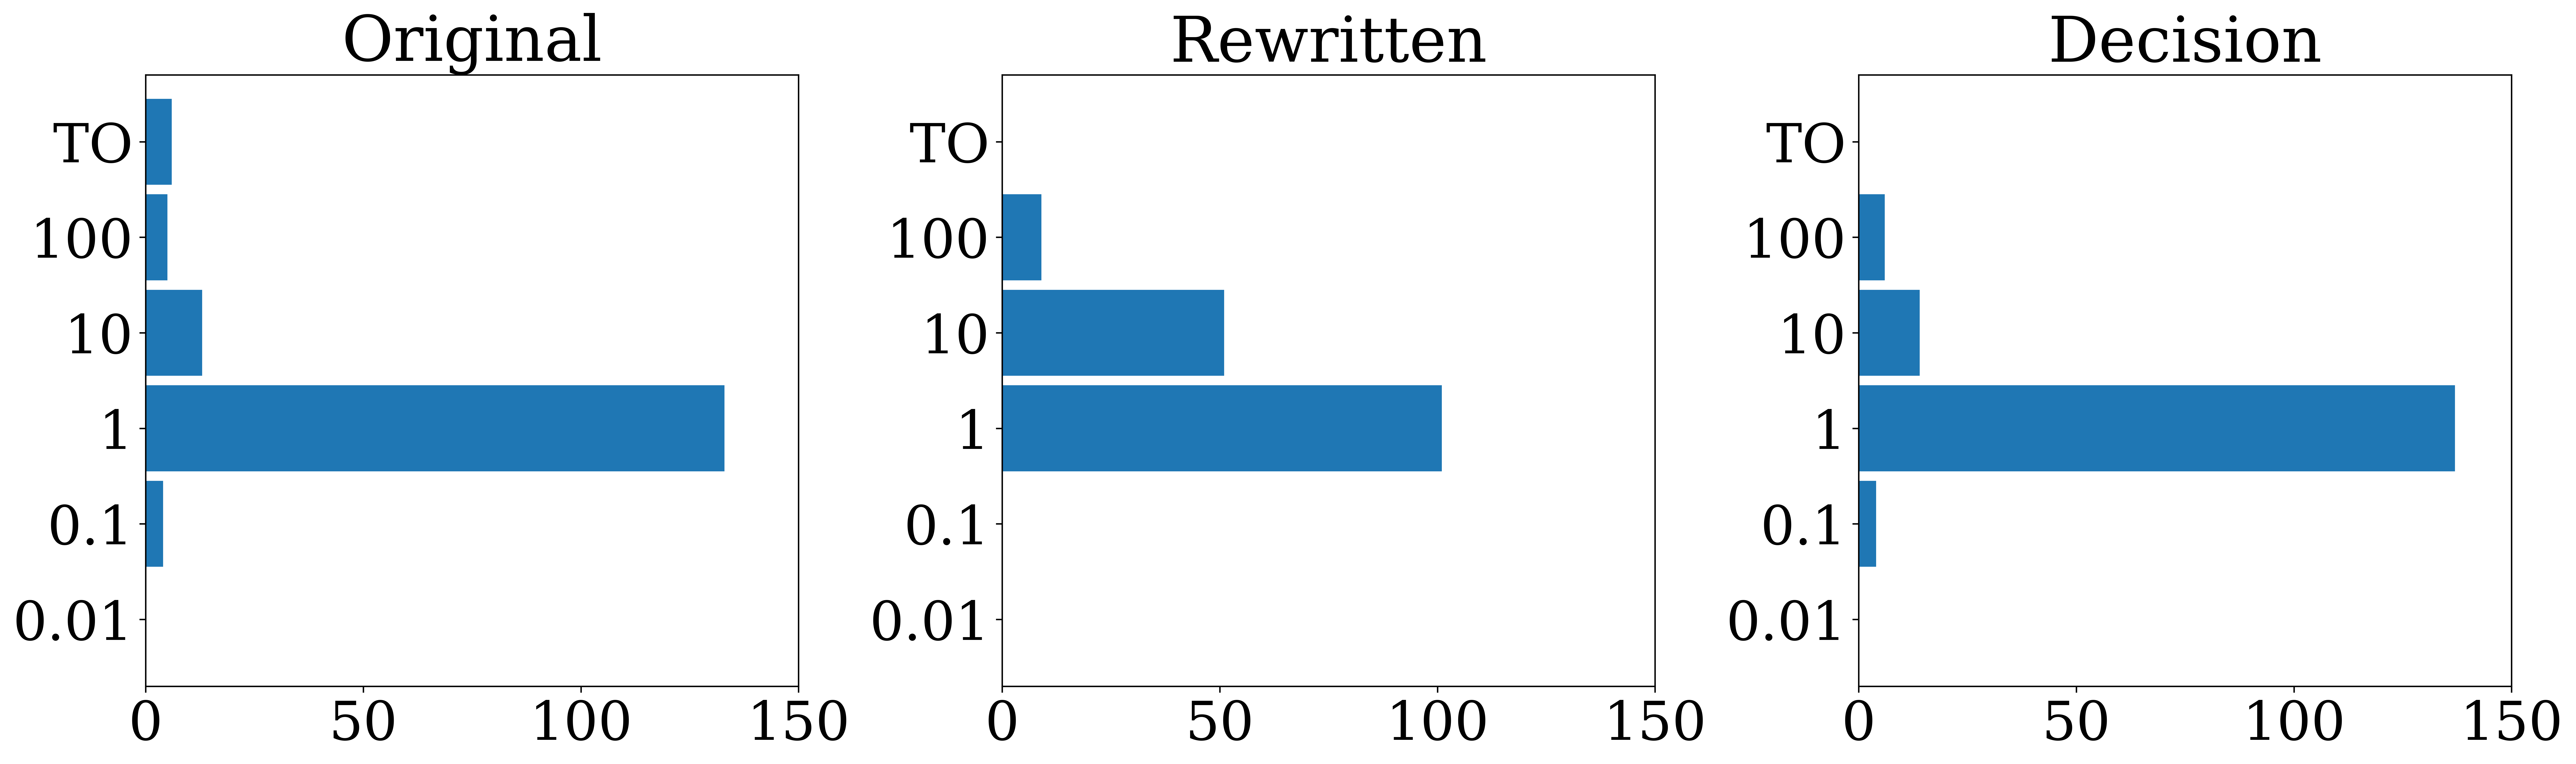

In [50]:
test_set["orig(med)"] = test_set['orig(med)'].astype("float64")
test_set["rewr(med)"] = test_set['rewr(med)'].astype("float64")
test_set["pred(med)"] = test_set['pred(med)'].astype("float64")
bins = [0, 0.01, 0.1, 1, 10, 99.99, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']
test_set['interval orig'] = pd.cut(test_set['orig(med)'], bins=bins, labels=labels)
test_set['interval rewr'] = pd.cut(test_set['rewr(med)'], bins=bins, labels=labels)
test_set['interval pred'] = pd.cut(test_set['pred(med)'], bins=bins, labels=labels)

grouped_orig = test_set['interval orig'].value_counts().sort_index()
grouped_rewr = test_set['interval rewr'].value_counts().sort_index()
grouped_pred = test_set['interval pred'].value_counts().sort_index()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

fontsize = 30
titlesize = 35
xlim = 150

# Plot for 'orig mean'
grouped_orig.plot(kind='barh', stacked=True, ax=ax1, width = 0.9)
ax1.set_xlim(0,xlim)
#ax1.set_xlabel('Count', fontsize=fontsize)  # Increase font size for x-axis label
#ax1.set_ylabel('Order of magnitude', fontsize=fontsize)  # Increase font size for y-axis label
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_title('Original', fontsize=titlesize)  # Increase font size for title
ax1.tick_params(axis='both', which='major', labelsize=fontsize)

# Plot for 'rewr mean'
grouped_rewr.plot(kind='barh', stacked=True, ax=ax2, width = 0.9)
#ax2.set_xlabel('Count', fontsize=fontsize)
#ax2.set_ylabel('Order of magnitude', fontsize=fontsize)
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('Rewritten', fontsize=titlesize)
ax2.set_xlim(0,xlim)
ax2.tick_params(axis='both', which='major', labelsize=fontsize)

# Plot for 'pred mean'
grouped_pred.plot(kind='barh', stacked=True, ax=ax3, width = 0.9)
#ax3.set_xlabel('Count', fontsize=fontsize)
#ax3.set_ylabel('Order of magnitude', fontsize=fontsize)
ax3.set_xlabel('')
ax3.set_ylabel('')
ax3.set_title('Decision', fontsize=titlesize)
ax3.set_xlim(0,xlim)
ax3.tick_params(axis='both', which='major', labelsize=fontsize)

plt.tight_layout()
plt.savefig('plots/SPA_enum_runtimes.png')
plt.show()